# 最小二乗法

In [1]:
import numpy as np

class PolynomialLeastSquare:
    """
    多項式最小二乗法
    
    Attributes
    ----------
    coefficients : int
        使用する弱分類器の数
    d : int
        fitting を行う多項式の次数
    """
    
    def fit(self, x, y, d):
        """
        回帰曲線の係数を計算
        
        Parameters
        ----------
        x : numpy array [float]
        y : numpy array [float]
        d : int
            fitting する多項式の次数
        """
        n = len(x)
        # x のべき乗を計算
        x_pow = [np.full(n, 1.)]
        for i in range(2*d):
            x_pow.append(x_pow[-1] * x)
        x_pow = np.array(x_pow)
        # 行列 S を計算
        s = []
        for i in range(2*d+1):
            s.append(np.sum(x_pow[i]))
        S = np.zeros([d+1, d+1])
        for i in range(d+1):
            for j in range(d+1):
                S[i][j] = s[i+j]
        # ベクトル t を計算
        t = []
        for i in range(d+1):
            t.append(np.sum(x_pow[i]*y))
        t = np.matrix(t).T
        # 係数を求める
        S_inv = np.linalg.inv(S)
        self.coefficients = np.array(np.dot(S_inv, t)).flatten()
        self.d = d
    
    def predict(self, x):
        """
        学習済み回帰曲線を使って未知の x を変換
        
        Parameters
        ----------
        x : numpy array [float]
        """
        x_pow = np.full(len(x), 1.)
        y = np.zeros(len(x))
        for i in range(len(self.coefficients)):
            y += x_pow * self.coefficients[i]
            x_pow *= x
        return y

[9.51688881 1.21328973 0.28345144 0.20000356 0.01067584]


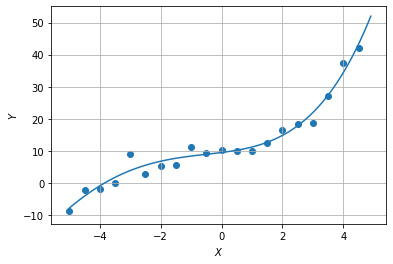

In [2]:
%matplotlib inline
from matplotlib import pyplot as plt

# データ作成
x = np.arange(-5, 5, 0.5)
y = x + 0.5*x**2 + 0.2*x**3 + 5 + np.random.rand(len(x))*8

# fitting
ls = PolynomialLeastSquare()
ls.fit(x, y, 4)

# 描画
print(ls.coefficients)
# [8.23115198 0.96170651 0.43909691 0.21033719 0.00980294]
xp = np.arange(-5, 5, 0.1)
yp = ls.predict(xp)
plt.xlabel('$X$')
plt.ylabel('$Y$')
plt.plot(xp, yp)
plt.scatter(x, y)
plt.grid()
plt.show()

In [3]:
import numpy as np

class RANSAC:
    """
    Attributes
    ----------
    mse : float
        平均二乗誤差 (Mean Square Error)
    ls_best : object
        最適な最小二乗法モデル
    x_inliers_best : numpy array [float]
        最適モデルを学習した際の正常値 x
    y_inliers_best : numpy array [float]
        最適モデルを学習した際の正常値 y
    """
    
    def __init__(self, max_trials, residual_threshold, min_inliers_rate):
        """
        Parameters
        ----------
        max_trials : int
            ランダムサンプリングによる fitting を試行する最大回数
        residual_threshold : float
            ランダムサンプルから学習したモデルとの残差がこれ以内であれば「正常値」とみなす
        min_inliers_rate : float
            [0, 1] の小数。データサンプル全体に占める正常値の割合がこれ以下のものは最適モデルの候補に含めない
        """
        self.max_trials = max_trials
        self.residual_threshold = residual_threshold
        self.min_inliers_rate = min_inliers_rate
    
    def predict(self, x):
        return self.ls_best.predict(x)
    
    def fit(self, x, y, d):
        """
        Parameters
        ----------
        x : numpy array [float]
        y : numpy array [float]
        d : int
            fitting する多項式の次数
        """
        n = len(x)
        # ランダムサンプリングの件数は最小限（モデルの自由度と同じ）にする
        n_part = d+1
        mse_min = np.inf
        ls_best = None
        x_inliers_best = None
        y_inliers_best = None
        for t in range(self.max_trials):
            ids_part = np.random.choice(n, n_part, replace=False)
            x_part, y_part = x[ids_part], y[ids_part]
            ls_part = PolynomialLeastSquare()
            ls_part.fit(x_part, y_part, d)
            ids_inliers = self.__detect_inliers_indices(x, y, ls_part)
            if len(ids_inliers) / n < self.min_inliers_rate:
                continue
            x_inliers, y_inliers = x[ids_inliers], y[ids_inliers]
            ls_inliers = PolynomialLeastSquare()
            ls_inliers.fit(x_inliers, y_inliers, d)
            mse = self.__calc_mse(x_inliers, y_inliers, ls_inliers)
            if mse < mse_min:
                mse_min = mse
                ls_best = ls_inliers
                x_inliers_best, y_inliers_best = x_inliers, y_inliers
        self.mse = mse_min
        self.ls_best = ls_best
        self.x_inliers_best, self.y_inliers_best = x_inliers_best, y_inliers_best
    
    def __detect_inliers_indices(self, x, y, model):
        """
        回帰モデルに対する正常値（のインデックス）を見つける
        """
        y_pred = model.predict(x)
        return np.where(np.abs(y-y_pred) < self.residual_threshold)[0]
    
    def __calc_mse(self, x, y, model):
        """
        回帰モデルに対するデータの平均二乗誤差（MSE）を計算
        """
        y_pred = model.predict(x)
        return np.average((y_pred-y)**2)

6.369557871749816
[6.09388684 0.92936235 0.37627244 0.18876938]
[16.09783541  1.51332226  0.23445353  0.19353104]


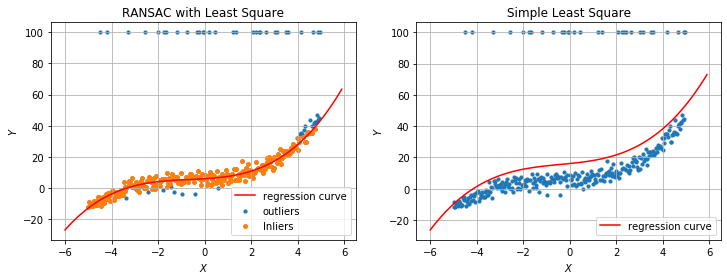

In [4]:
%matplotlib inline
from matplotlib import pyplot as plt

# データ作成
N = 300
x = np.arange(-5, 5, 10/N)
y = x + 0.5*x**2 + 0.2*x**3 + 5 + np.random.randn(len(x))*3
y[np.random.choice(N, N//10, replace=False)] = 100

# RANSAC の fitting
rs = RANSAC(max_trials=100, residual_threshold=10, min_inliers_rate=0.8)
rs.fit(x, y, 3)
print(rs.mse)
# 6.369557871749816
print(rs.ls_best.coefficients)
# [6.09388684 0.92936235 0.37627244 0.18876938]

# 単純な最小二乗法の fitting
ls = PolynomialLeastSquare()
ls.fit(x, y, 3)
print(ls.coefficients)
# [16.09783541  1.51332226  0.23445353  0.19353104]

# 回帰曲線を描画
xp = np.arange(-6, 6, 0.1)
yp_rs = rs.predict(xp)
yp_ls = ls.predict(xp)
fig, (axL, axR) = plt.subplots(ncols=2, figsize=(12,4))
axL.set_title('RANSAC with Least Square')
axL.set_xlabel('$X$')
axL.set_ylabel('$Y$')
axL.scatter(x, y, s=10, label='outliers')
axL.scatter(rs.x_inliers_best, rs.y_inliers_best, s=15, label='Inliers')
axL.plot(xp, yp_rs, c='r', label='regression curve')
axL.grid()
axL.legend()
axR.set_title('Simple Least Square')
axR.set_xlabel('$X$')
axR.set_ylabel('$Y$')
axR.scatter(x, y, s=10)
axR.plot(xp, yp_ls, c='r', label='regression curve')
axR.grid()
axR.legend()
plt.show()

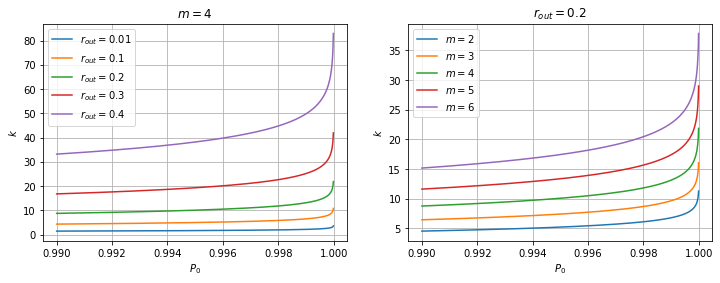

In [5]:
dp = 0.00001
p = np.arange(0.99, 1-dp, dp)

fig, (axL, axR) = plt.subplots(ncols=2, figsize=(12,4))

m=4
for r in [0.01, 0.1, 0.2, 0.3, 0.4]:
    k = np.log(1-p) / np.log(1-(1-r)**m)
    axL.plot(p, k, label='$r_{{out}}={}$'.format(r))
axL.set_title('$m=4$')
axL.set_xlabel('$P_0$')
axL.set_ylabel('$k$')
axL.legend()
axL.grid()


r = 0.2
for m in [2, 3, 4, 5, 6]:
    k = np.log(1-p) / np.log(1-(1-r)**m)
    axR.plot(p, k, label='$m={}$'.format(m))
axR.set_title('$r_{{out}}={}$'.format(r))
axR.set_xlabel('$P_0$')
axR.set_ylabel('$k$')
axR.legend()
axR.grid()

plt.show()

$$
\begin{eqnarray}
&p_0 \le 1 - \{ 1 - (1 - r_{\rm out})^m \}^k \\
\Longleftrightarrow\ & \{ 1 - (1 - r_{\rm out})^m \}^k \le 1 - p_0 \\
\Longleftrightarrow\ & k \log \{ 1 - (1 - r_{\rm out})^m \} \le \log (1 - p_0)
\end{eqnarray}
$$

対数の中は1より小さいから、対数は負になる。よって

$$
k \ge \cfrac{\log (1 - p_0)}{\log \{ 1 - (1 - r_{\rm out})^m \}}
$$

$$
\begin{eqnarray}
\cfrac{{}_{n(1-r_{\rm out})} C_m}{{}_n C_m}
&=& \cfrac{n(1-r_{\rm out}) \{n(1-r_{\rm out})-1\} \cdots \{n(1-r_{\rm out})-m+1)\}}{n (n-1) \cdots (n-m+1)} \\
&\simeq& \cfrac{\{n(1-r_{\rm out})\}^m}{n^m} \\
&=& (1 - r_{\rm out})^m
\end{eqnarray}
$$
